# LRC Resonance

### Date: 20/05/19 - 21/05/19
### Group Members: Aayushi Verma, Diana Kommedal, Alex Goodenbour

## Introduction

LRC circuits consist of a inductor, capacitor, and resistor connected in series or parallel. LRC circuits act as harmonic oscillators for charge in a similar fashion to a mass on a spring or a simple pendulum. Like a mass on a spring, with a driving force of equal frequency to the systems resonant frequency, the amplitude of oscillations grows and thus when we have a driving force in the form of an alternating current set to the resonant frequency of the system, we observe amplification and a maximum current in this state. The classic example of these circuits is the tuning circuits of analogue radios. By adjusting either the capacitance or inductance, the resonant frequency of the circuit can be changed and thus the system amplifies a different frequency allowing a user to listen to different stations.



In this experiment we set out to measure the bandwidth and quality factor of a resonant LRC series circuit. We began by determining the inductance of a coil by finding the resonant frequency of the circuit. We then held the inductance and capacitance constant and changed the frequency of the AC supply to find a relationship between frequency and current and determine the resonant frequency, bandwidth and resistance of the circuit. We then held the frequency and inductance constant while changing the capacitance to find a relationship between frequency and capacitance. Next, we determined the quality factor of the LRC circuit using two different definitions, confirming that these were the same. We then added resistance to the circuit such that the quality factor dropped to 5 and plotted a frequency dependent resonance curve for this circuit. Finally, we tested the relationship between damped frequency and resonance frequency by comparing the observed frequency with the theoretical damped frequency for both quality factors used in this experiment. 

## Method

### Finding the Inductance of a Coil

The LRC circuit used in this experiment consisted of a constant alternating current voltage source with variable frequency and an ammeter, to which a 1412-BC General Radio Co. decade capacitor and inductor with non-zero internal resistance were connected. A Fluke voltmeter was set to its AC-volts scale and used give a reading for the source voltage. We then set the variable capacitor to a value calculated to give a resonant frequency of 550Hz. The resonant frequency of an LRC circuit is given by

$\omega_0 = \sqrt{\frac{1}{LC}}$

Therefore, as we know the coil has an average radius of 4 cm, we can calculate an estimate for the inductance and thus an estimate for the capacitance at which the resonant frequency will be 550 Hz. This inductance is given by

$L = \frac{1}{2}N^2\pi r \mu_0$

where $N$ is the number of coils, $r$ is the average radius of the coil, and $\mu_0$ is the permeability constant of $4\pi$$\times 10^{-7}$.

From this we gain an estimate of the capacitance of $0.56$ $\mu F$. By making small adjustments to the frequency, we can find the frequency that gives resonance for this capacitance and from this value, calculate a true experimental value for the inductance using the equation for resonant frequency above. With this inductance we can also find the true average radius of the coil using the inductance equation above.

### Finding the Resistance of the LRC Circuit

We know that the form of a frequency dependent resonance curve is

$I(\omega) = \frac{\gamma \omega I_{max}}{\sqrt{\omega^2\gamma^2+(\omega^2-\omega_0^2}}$

Therefore, if we measure a range of values for this relationship, we can fit a curve of this form to the data and thus estimate the parameters $I_{max}$, $\gamma$, and $\omega$. From the bandwidth $\gamma$, we can determine the resistance of the circuit by the relationship $\gamma = R/L$. Values were measured for this relationship by altering the frequency of the voltage source and recording the value of the ammeter built into the voltage source. A non-linear model was then fitted using $\chi$-square minimisation methods. Bandwidth $\gamma$ is also equal to the difference between the two angular frequencies at which the power is half of its maximum value or when the current falls to $I_{max}/\sqrt{2}$. This difference was shown on the resultant graph with a line. 


We can also consider the current as a function of capacitance. The above procedure was repeated but the frequency was held constant while the capacitance was changed and the current measured from the ammeter of the voltage source. A non-linear model of the form

$I(\omega) = \frac{V_0}{\sqrt{R^2+(\omega L-\frac{1}{LC})}}$

was fitted to the data. 

### Determination of Quality Factor

The quality factor $Q$ of an LRC circuit is defined as the voltage across the capacitor at resonance divided by the voltage across the source at resonance. Therefore, by setting the frequency to resonance by making small adjustments to the frequency to find the point at which current peaks, we can determine the quality factor of this circuit by measuring the voltage across the capacitor and the voltage across the source for this configuration. 

$Q = \frac{V_C}{V_S}$


where $V_C$ is the voltage across the capacitor, and $V_S$ is the voltage across the source. 


Quality factor can also be determined by the ratio between the resonant frequency and bandwidth of the circuit $Q = \omega_0/\gamma$. Using the first set of fitted values from the non-linear model above, we can calculate the quality factor and compare our two values.

### Changing Q by Adding Resistance

As bandwidth is a measure of damping in the system, we can alter the quality factor of an LRC circuit by adding a resistor in series. We begin by calculating the total resistance needed in the circuit for a quality factor of 5. This is given by the relationship  $R = \frac{\omega L}{Q}$ which can be found by combining the second equation for quality factor above with the equation $\gamma = R/L$. Once this resistance is found we subtract the calculated resistance of the inductor to find the resistance to be added to the circuit. Once this resistance is added to the circuit in the form of a 1432-J General Radio Co. decade resistor, we repeat the steps above to calculate a frequency dependent resonance curve and fit a non-linear model to these data points. From this, we can use the fitted parameters $\gamma$ and $\omega_0$ to find the experimental quality factor of the circuit by $Q = \omega_0/\gamma$ to ensure that we have succeeded in altering the quality factor to around 5.

### Resonant Frequency of a Lossy Resonant Circuit

We can see from the above equation that the resonant frequency occurs when the denominator is at a minimum and is therefore independent of resistance. However, the voltage across a capacitor is determined by the equation $|V_C| = |I|/|\omega C|$ and therefore its maximum occurs at a slightly shifted frequency determined by

$\omega_d = \sqrt{\omega_0^2-(\gamma / 2)^2} = \frac{\omega_0}{\sqrt{1+(1/2Q)^2}}$

We can test this relationship by measuring the voltage across the capacitor for a given frequency using the Model 75 fluke multimeter and comparing this value with the expected frequency shift given by the above equation. This equation suggests that for a lower quality factor, the shift from $\omega_0$ to $\omega_d$ would be greater for a smaller quality factor. 


## Analysis

### Setup and helper function definition

In [1]:
# Setup and helper function definition

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pds
from scipy.optimize import minimize
from scipy.stats import chisquare
from decimal import Decimal

# Rounds uncertainties to one significant figure
def round_to_1(x):
    return round(x, -int(np.floor(np.log10(abs(x)))))

# Model for I as a function of frequency
def model_w(params, w):
    I_max, w_0, gamma = params
    return (gamma*w*I_max)/np.sqrt(w**2*gamma**2+(w**2-w_0**2)**2)

# Model for I as a function of capacitance
def model_C(params, C):
    w = 553*2*np.pi
    R = 21.9014
    L = 0.1479
    V_0 = params
    return (V_0)/np.sqrt(R**2+(w*L-(1/(w*C)))**2)

# Chi Square test function
def chisqr(obs, exp, error):
    chisqr = 0
    for i in range(len(obs)):
        chisqr = chisqr + ((obs[i]-exp[i])**2)/(error[i]**2)
    return chisqr

# Wrapper on a the generalised chi square function above
# Last arg is an anonymous function to generalise
def chi2(params, data ,model):
    
    x = data[:,0]
    y = data[:,1]
    err = data[:,2]
    #sigma = data [:,2]
    
    expected = model(params, x)
    #return chisquare(y, expected)[0]
    return chisqr(y, expected, err)

    
# Fits data points to model
# Example:   "params, unc = calc_model(guesses, np.column_stack((x, y)))"
def calc_model(guesses, pnts, fn):
    result = minimize(chi2,guesses, method='BFGS',args=(pnts,fn))
    param_unc = np.sqrt(2*np.diag(result.hess_inv))
    newparams = result.x
    #print(newparams)
    return newparams, param_unc

def plot_model(xlow, xhigh, fn, params, label, lstyle="-", colour="c"):
    xx = np.linspace(xlow, xhigh, 1000)
    plt.plot(xx, fn(params, xx), linestyle=lstyle, color=colour, label=label)


# Unit conversion lambdas
in_to_cm = lambda x: 2.54*x

# Importing the data
data = pds.read_csv("lrc.csv")

### Inductance of a Coil

In [2]:
V_meas_unc = lambda x: 0.05*x
I_meas_unc = V_meas_unc
w_meas_unc = 1*2*np.pi

L_from_res = lambda w_0, C: 1/(w_0**2*C)
r_from_L = lambda N, L, M_0: (2*L)/(N**2*np.pi*M_0)

M_0 = np.pi*4e-7 # See reference [1]

C = 0.56e-6
w_0 = 553*2*np.pi
N = 1500

L_coil = L_from_res(w_0, C)
L_coil_unc = L_coil*(2*w_meas_unc)/(w_0) # Propagation of Uncertainties (unc in C negligible compared to unc in w)

r_coil = r_from_L(N, L_coil, M_0)
r_coil_unc = r_coil*L_coil_unc/L_coil

print("Inductance of Coil:", round(L_coil,4),"±", round_to_1(L_coil_unc),"H")
print("Average Radius of Coil: ", round(r_coil*1e2, 4), "±", round_to_1(r_coil_unc), "cm")

Inductance of Coil: 0.1479 ± 0.0005 H
Average Radius of Coil:  3.3303 ± 0.0001 cm


### Resonance Curves

I_max Experimental: 89 ± 4 mA
w_0 Experimental: 552.0 ± 0.4 Hz
Gamma Experimental: 145 ± 9 rad/s

Experimental Resistance: 21 ± 1 Ω
Observed Bandwidth: 140 rad/s

Experimental V_0:  1.91 ± 0.02 V


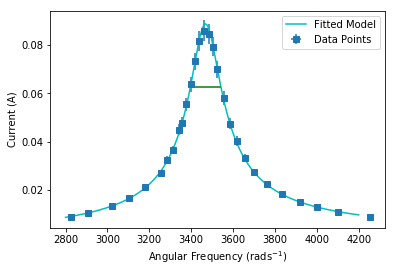

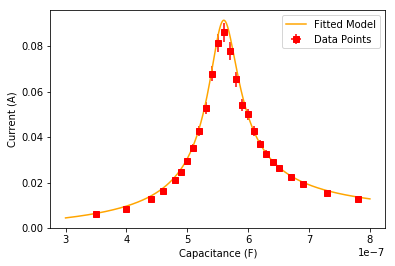

In [3]:
## For I(w) and I(C)

xx = np.linspace(0,10,1000)

w = np.array(data.frequency_w)*np.pi*2
w = w[~np.isnan(w)]
I = np.array(data.current_w)*1e-3
I = I[~np.isnan(I)]

guesses = (85e-3,3500,L_coil*1000)

params, unc = calc_model(guesses, np.column_stack((w,I, I*0.05)), model_w)
unc1 = unc
#print("Fitted Params: ", params)

plt.figure(1)

plot_model(2800, 4200, model_w, params, "Fitted Model")
plt.errorbar(w, I, I*0.05, 0, linestyle="none", marker="s", label="Data Points")

#plt.title("Finding the Resistance of an LRC Circuit")
plt.xlabel("Angular Frequency (rads$^{-1}$)")
plt.ylabel("Current (A)")
plt.legend()

[I_max_exp, w_0_exp, gamma_exp] = params
#print(unc)
print("I_max Experimental:", int(round(Decimal(I_max_exp*1e3),0)),"±", int(round_to_1(unc[0]*1e3)) ,"mA")
print("w_0 Experimental:", round(Decimal(w_0_exp/(2*np.pi)),1), "±", round_to_1(unc[1]/(2*np.pi)),"Hz")
print("Gamma Experimental:", int(round(Decimal(gamma_exp),0)), "±", int(round_to_1(unc[2])), "rad/s")
print()
R_exp = gamma_exp*L_coil
R_exp_unc = np.sqrt((L_coil*unc[2])**2+(gamma_exp*L_coil_unc)**2)
print("Experimental Resistance:", int(round(R_exp,0)),"±", int(round_to_1(R_exp_unc)),"Ω")

# Add in bandwidth line
g1 = 3400
g2 = 3540
plt.plot([g1,g2],[I_max_exp/np.sqrt(2),I_max_exp/np.sqrt(2)], linestyle="-", color="g")
gamma_length = g2-g1
print("Observed Bandwidth:", gamma_length, "rad/s")

plt.figure(2)

cap = np.array(data.cap_c)*1e-6
cap = cap[~np.isnan(cap)]
I_c = np.array(data.current_c)*1e-3
I_c = I_c[~np.isnan(I_c)]

guesses = (2)

params, unc = calc_model(guesses, np.column_stack((cap,I_c, I_c*0.05)), model_C)
#print(unc)
#print("Fitted Params: ", params)

plot_model(0.0000003, 0.0000008, model_C, guesses, "Fitted Model", colour="orange")
plt.errorbar(cap, I_c, I_c*0.05, 0, linestyle="none", marker="s", color="r", label="Data Points")
#plt.title("Finding the something of an LRC Circuit")
plt.xlabel("Capacitance (F)")
plt.ylabel("Current (A)")
print()
#print(unc)
plt.legend()
print("Experimental V_0: ", round(Decimal(params[0]),2),"±", round_to_1(unc[0]), "V")


### Determination of $Q$

In [4]:
## From Q = V_C / V_S
## and from Q = w_0/gamma from fitted params

Q_exp_1 = data.v_c[0]/data.v_s[0]
Q_exp_1_unc = np.sqrt((1+data.v_c[0])/data.v_s[0])*V_meas_unc(data.v_c[0])

Q_exp_2 = w_0_exp/gamma_exp
Q_exp_2_unc = np.sqrt(((1/gamma_exp)*(unc1[1]))**2+(Q_exp_2*(1/gamma_exp)*(unc1[2]))**2)

print("Experimental Q from Voltage Ratio:", int(round(Q_exp_1,-1)), "±", int(round_to_1(Q_exp_1_unc)))
print("Experimental Q from fitted values:", int(round(Q_exp_2,0)), "±", int(round_to_1(Q_exp_2_unc)))

Experimental Q from Voltage Ratio: 20 ± 10
Experimental Q from fitted values: 24 ± 1


### Altering $Q$ by Adding Resistance

Total Resistance needed in circuit: 102.61 Ω
Resistance Needed in Variable Resistor: 81.12 Ω
Gamma Experimental: 675.3 ± 0.1 rad/s

Experimental Resistance: 99.9 ± 0.4 Ω
Experimental Quality Factor: 5.139 ± 0.002


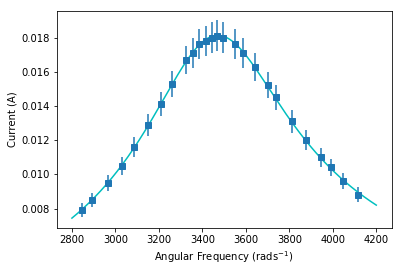

In [5]:
R_5 = (w_0_exp*L_coil)/5
print("Total Resistance needed in circuit:", round(Decimal(R_5),2), "Ω")
R_var_res = R_5-R_exp
print("Resistance Needed in Variable Resistor:", round(Decimal(R_var_res),2), "Ω")

w_5 = np.array(data.freq_5)*np.pi*2
w_5 = w_5[~np.isnan(w_5)]
I_5 = np.array(data.current_5)*1e-3
I_5 = I_5[~np.isnan(I_5)]

guesses = (0.02,3500,L_coil*1000)

params5, unc = calc_model(guesses, np.column_stack((w_5,I_5, I_5*0.05)), model_w)

plt.figure(1)

plot_model(2800, 4200, model_w, params5, "Fitted Model")
plt.errorbar(w_5, I_5, I_5*0.05, 0, linestyle="none", marker="s", label="Data Points")
#plt.title("Finding the Quality Factor of an LRC Circuit")
plt.xlabel("Angular Frequency (rads$^{-1}$)")
plt.ylabel("Current (A)")

[I_max_exp_5, w_0_exp_5, gamma_exp_5] = params5

Q_exp_5 = w_0_exp_5/gamma_exp_5
Q_exp_5_unc = np.sqrt(((1/gamma_exp_5)*(unc[1]))**2+(Q_exp_5*(1/gamma_exp_5)*(unc[2]))**2)

print("Gamma Experimental:", round(Decimal(gamma_exp_5),1), "±", round_to_1(unc[2]), "rad/s")
print()
R_exp_5 = gamma_exp_5*L_coil
R_exp_5_unc = np.sqrt((L_coil*unc[2])**2+(gamma_exp_5*L_coil_unc)**2)
print("Experimental Resistance:", round(Decimal(R_exp_5),1),"±",round_to_1(R_exp_5_unc),"Ω")
print("Experimental Quality Factor:", round(Decimal(Q_exp_5),3), "±", round_to_1(Q_exp_5_unc))

###  Resonant Frequency of a Lossy Resonant Circuit

In [6]:
f_d = lambda f_0, Q: (f_0)/np.sqrt(1+(1/(2*Q))**2)
f_d_unc = lambda f_0, Q, f_0_unc, Q_unc: np.sqrt((f_0_unc**2)/(1+(1/(2*Q)**2))+(f_0**2*Q_unc**2)/(9*Q**6*(1+(1/(2*Q))**2)**3))


# First quality factor
Q_1 = 23.42
f_11 = 552
I_max_11 = 86
V_c_11 = 46

f_12 = 552
I_12 = 86
V_c_max_12 = 46.1

theoretical_f_d_1 = f_d(f_11, Q_1)
theoretical_f_d_1_unc = f_d_unc(f_11, Q_1, 1, 1)

print("Quality factor {} - Observed f_d: {} Hz".format(Q_1,f_12))
print("Quality factor {} - Theoretical f_d: {} ± {} Hz".format(Q_1,int(round(theoretical_f_d_1,0)), int(np.ceil((theoretical_f_d_1_unc)))))


# Second quality factor
Q_2 = 5
f_21 = 553
I_max_21 = 18
V_c_21 = 0.479

f_22 = 550
I_22 = 18
V_c_max_22 = 0.485

theoretical_f_d_2 = f_d(f_21, Q_2)
theoretical_f_d_2_unc = f_d_unc(f_21, Q_2, 1, 0.002)
print("Quality factor {} - Observed f_d: {} Hz".format(Q_2, f_22))
print("Quality factor {} - Theoretical f_d: {} ± {} Hz".format(Q_2, int(theoretical_f_d_2), int(np.ceil(theoretical_f_d_2_unc))))

Quality factor 23.42 - Observed f_d: 552 Hz
Quality factor 23.42 - Theoretical f_d: 552 ± 1 Hz
Quality factor 5 - Observed f_d: 550 Hz
Quality factor 5 - Theoretical f_d: 550 ± 1 Hz


## Discussion

Looking back on this experiment, there were several areas that raised questions regarding the validity of our results. One such example was the values and uncertainty returned by the the algorithm used to fit the non-linear model for a resonance curve to our data. This curve was fitted by adjusting several parameters which were returned with uncertainties by the algorithm. The fitting algorithm works by taking in a set of guess parameters that give a general indication of the region of each parameter and by minimising the $\chi$-square test on these parameters compared to the data, we could find the parameters that best suited the data we had collected. The algorithm also returned an inverse hessian matrix which could be used to calculate the uncertainty associated with each parameter. In the early stages of this experiment, we used an implementation of the $\chi$-square test built into the SciPy library for Python. This gave us valid values for the parameters but extremely large uncertainties. When this implementation of the $\chi$-square test was rewritten, the uncertainties for the parameters became far more reasonable. However, the fitted parameters and their uncertainties from our non-linear models made up the majority of results in this experiment and so this highlights the importance of fully understanding the implementation of any analysis code. Without an understanding of how our code works, we can not be confident in the results of a given experiment and therefore if this experiment were to be repeated, we would go further in ensuring that we understand the steps taken by all external libraries in determining values and uncertainties used.

Another cause for concern was the magnitude of the uncertainties in the results of this experiment. The majority of results had reasonable uncertainties attached to them, however some had uncertainties in the range of 10% of their value, suggesting that either our methods of measurement must be improved or that our methods of uncertainty calculation should be examined. As the measurement in this experiment primarily involved voltage and current, two quantities that can be very accurately measured, it would seem that the flaw in these uncertainties is in their calculation. One possible explanation for this is that there is a source of uncertainty in the measurement not included in the percentage value for uncertainty given by the manufacturers of the equipment used. Such a source of uncertainty could be introduced by several factors such as a flaw in the equipment used, or more likely a flaw in the measurement process of those who carried out the experiment. Another explanation for the discrepancies in some of the uncertainties of the results of this experiment is the modelling function discussed above. Although most of the uncertainties returned by this algorithm were sensible, we have no benchmark for what is and what isn't an acceptable uncertainty and so there may still be an issue with the methods of uncertainty calculation used by this algorithm. Therefore, if we were to repeat this experiment, we would make sure to examine each stage of the propagation of uncertainties to find sources of error in uncertainty calculation and fix any broken links so that the flow of uncertainty propagation could continue unimpeded.

## Conclusion

In this experiment, we measured the bandwidth and quality factor of a resonant LRC series circuit. We began by determining the inductance of a coil by finding the resonant frequency of the circuit. It was found to be $0.1479 \pm 0.0005$ $H$ and the average radius of the coil to be $3.3303 \pm 0.0001$ $cm$. We then found a frequency dependent resonance relationship and determined the experimental resonant frequency, bandwidth and resistance of the circuit from this relationship. The resistance of the circuit was found to be $21 ± 1$ $\Omega$. We then held the frequency and inductance constant while changing the capacitance to find a capacitance dependent resonance relationship. Next, we determined the quality factor of the LRC circuit using two different methods, confirming that these returned the same value. We then added resistance to the circuit such that the quality factor dropped to 5 and plotted a frequency dependent resonance curve for this circuit. Finally, we tested the relationship between damped frequency and resonance frequency by comparing the observed frequency with the theoretical damped frequency for both quality factors used in this experiment.

By finding values for bandwidth, quality factor, and other parameters of a resonance curve, we have demonstrated the use of an LRC circuit as a harmonic oscillator and shown how the basic characteristics of this circuit allow it to be used in such a wide variety of applications from a simple analogue radio to dynamic filters for audio.

## References

\[1\] Peter J Mohr, David B Newell, and Barry N Taylor.  Codata recommendedvalues of the fundamental physical constants:  2014.Journal of Physical andChemical Reference Data, 45(4):043102, 2016.